In [946]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

driver_CAC = 500  # average driver acquisition cost
rider_CAC = 15  # average rider acquisition cost
base_driver_wage = 19  # minimum driver wage
base_ride_price = 25  # prevailing price
base_driver_churn = 0.05  # base driver churn rate
base_rider_churn = 0.1  # base rider churn rate
fail_rider_churn = 0.33  # rider churn rate when failed to find driver
min_match_rate = 0.6 # 60% match rate at base_driver_wage
max_match_rate = 0.93  # 95% is the maximum achievable match rate
min_take_rate = 3 # minimum commission by Lyft
max_take_rate = 6 # maximum commission by Lyft
rides_per_driver = 100  # number of rides completed by a driver in a month
rides_per_rider = 1  # number of rides requested by a rider in a month
total_eligible_riders = 250000 / 12 # max number of people travelling via Toledo, OH airport monthly
total_eligible_drivers = 500 # max number of available drivers in Toledo
starting_riders = 100 # number of riders at start (25% of monthly volume)
starting_drivers = 1 # number of drivers at start
monthly_driver_budget = driver_CAC * 1 # monthly budget for acquiring drivers
monthly_rider_budget = rider_CAC * 100 # monthly budget for acquiring riders

In [947]:
def calculate_driver_churn(wage):
    return base_driver_churn

def calculate_match_rate(take_rate):
    # 60% match at $6 commission
    # 93% match at $3 commission
    if take_rate <= min_take_rate:
        return max_match_rate

    take_range = max_take_rate - min_take_rate
    match_rate_range = max_match_rate - min_match_rate
    take_rate_percent = 1 - ((take_rate - min_take_rate) / take_range)
    match_rate = min(max_match_rate, min_match_rate + (match_rate_range * take_rate_percent))

    return match_rate

def calculate_rider_churn(match_rate, n_riders, completed_rides):
    # successful rides = 10% churn
    # failed rides = 33% churn
    failed_riders = n_riders - completed_rides
    
    return (failed_riders * (1 - fail_rider_churn)) + (completed_rides * (1 - base_rider_churn))

def simulate(take_rate, n_drivers=starting_drivers, n_riders=starting_riders, driver_budget=monthly_driver_budget, rider_budget=monthly_rider_budget):
    wage = base_ride_price - take_rate
    revenue = 0
    costs = 0
    match_rate = calculate_match_rate(take_rate)
    driver_churn = calculate_driver_churn(wage)
    
    for month in range(12):
        # Calculate rides
        possible_rides = min(n_drivers * rides_per_driver, n_riders * rides_per_rider)
        completed_rides = match_rate * possible_rides
        revenue += completed_rides * take_rate

        # Update drivers and riders
        n_drivers = (1 - driver_churn) * n_drivers
        n_riders = calculate_rider_churn(match_rate, n_riders, completed_rides)

        # Acquire new drivers and riders
        new_drivers = driver_budget // driver_CAC  # Number of drivers we can acquire with a fixed budget
        new_riders = rider_budget // rider_CAC  # Number of riders we can acquire with a fixed budget
        costs += (new_drivers * driver_CAC + new_riders * rider_CAC)
        n_drivers = min(total_eligible_drivers, n_drivers + new_drivers)
        n_riders = min(total_eligible_riders, n_riders + new_riders)

    return revenue - costs

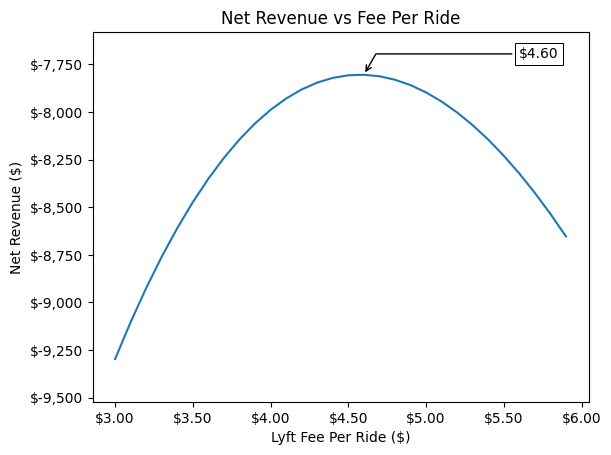

In [948]:
# Run the simulation for a range of commissions
take_rates = np.arange(min_take_rate, max_take_rate, 0.1)
net_revenues = [simulate(take_rate) for take_rate in take_rates]

# Plot the results
fig, ax = plt.subplots()

# Define a custom formatting function
def format_dollars(x, pos):
    return '${:,.0f}'.format(x)

# Apply the custom function to the y axis
formatter = ticker.FuncFormatter(format_dollars)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter('${x:1.2f}')

# Annotate fee at max revenue
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "${:1.2f}".format(xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(take_rates, net_revenues)

plt.plot(take_rates, net_revenues)
plt.xlabel('Lyft Fee Per Ride ($)')
plt.ylabel('Net Revenue ($)')
plt.title('Net Revenue vs Fee Per Ride')
plt.margins(y=0.15)
plt.show()

ideal_commission_rate = round(take_rates[np.argmax(net_revenues)], 2)

In [949]:
def simulate_with_tracking(take_rate, months, n_drivers=starting_drivers, n_riders=starting_riders, driver_budget=monthly_driver_budget, rider_budget=monthly_rider_budget):
    wage = base_ride_price - take_rate
    revenue = 0
    costs = 0

    drivers_over_time = []
    riders_over_time = []
    
    match_rate = calculate_match_rate(take_rate)
    driver_churn = calculate_driver_churn(wage)

    for month in range(months):
        # Calculate rides
        possible_rides = min(n_drivers * rides_per_driver, n_riders * rides_per_rider)
        completed_rides = match_rate * possible_rides
        revenue += completed_rides * take_rate

        # Update drivers and riders
        n_drivers = (1 - driver_churn) * n_drivers
        n_riders = calculate_rider_churn(match_rate, n_riders, completed_rides)

        # Acquire new drivers and riders
        new_drivers = driver_budget // driver_CAC  # Number of drivers we can acquire with a fixed budget
        new_riders = rider_budget // rider_CAC  # Number of riders we can acquire with a fixed budget
        costs += (new_drivers * driver_CAC + new_riders * rider_CAC)
        n_drivers = min(total_eligible_drivers, n_drivers + new_drivers)
        n_riders = min(total_eligible_riders, n_riders + new_riders)

        drivers_over_time.append(n_drivers)
        riders_over_time.append(n_riders)

    return drivers_over_time, riders_over_time

In [950]:
def run_timeline_projection(commission_rate, months):
    # Run the simulation for the chosen take rate
    drivers_over_time, riders_over_time = simulate_with_tracking(commission_rate, months)

    # Create the plot
    fig, ax = plt.subplots()

    months_range = range(1, months + 1)
    ax.plot(months_range, drivers_over_time, label='Drivers')
    ax.plot(months_range, riders_over_time, label='Riders')

    ax.set_xlabel('Month')
    ax.set_ylabel('Drivers / riders')
    ax.set_title(f'Drivers and riders over {months} months with ${commission_rate} Lyft fee')
    ax.legend()

    plt.show()

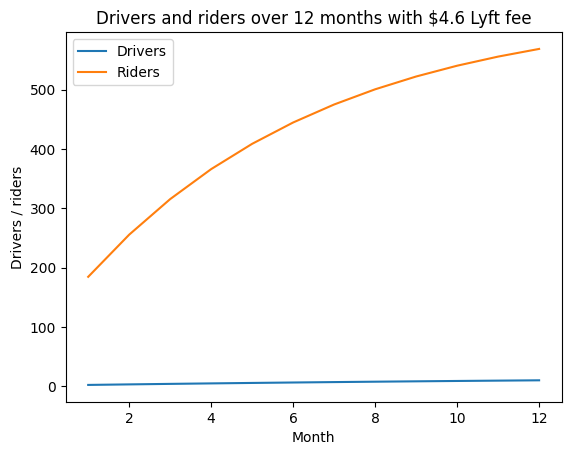

In [951]:
run_timeline_projection(ideal_commission_rate, 12)

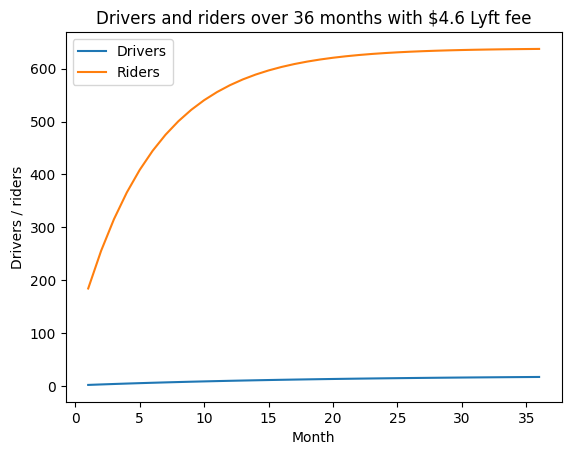

In [952]:
run_timeline_projection(ideal_commission_rate, 36)